In [1]:
import momepy as mm
import numpy as np
import numba
import geopandas as gpd
import pandas as pd
import shapely
from sklearn.preprocessing import StandardScaler
from collections import namedtuple
from core.cluster_validation import get_linkage_matrix
from libpysal.graph import read_parquet, Graph
from core.generate_context import spatially_weighted_partial_lag
from core.generate_clusters import preprocess_clustering_data
from sklearn.cluster import AgglomerativeClustering
from core.cluster_validation import get_linkage_matrix
from scipy.cluster.hierarchy import fcluster
from core.utils import used_keys

In [2]:
regions_datadir = "/data/uscuni-ulce/"
morphotopes_dir = '/data/uscuni-ulce/processed_data/morphotopes/'
model_params = '_75_0_None_None_False'
clip = None
to_drop = [
        'stcSAl','stbOri','stcOri','stbCeA',
        'ldkAre', 'ldkPer', 'lskCCo', 'lskERI','lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe',
          # 'licBAD',
    # 'misBAD',
    # 'ssbCCM','ssbCCD'    
]


linkage = 'ward'
metric = 'euclidean'

morphotope_stat_columns = ['percentile_25', 'percentile_75', 'mean', 'std']

In [3]:
def preprocess_data(data, scalar, drop_columns=morphotope_stat_columns):
    component_data = data.drop(columns=drop_columns, level=1)
    component_data = component_data.drop(columns=to_drop, level=0)
    component_data.columns =  component_data.columns.get_level_values(0)
    
    component_data = component_data[component_data.index.str[-2:] != '-1']
    
    vals = scalar.fit_transform(component_data)
    component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
    component_data = component_data.drop(component_data.columns[component_data.std() == 0], axis=1)
    
    # component_data = component_data[component_data.index >= 0]
    vals = np.nan_to_num(component_data)
    component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
    return component_data

def read_region_morphotope_data(region_id, scalar):
    print('processing' , region_id)
    data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
    data.index = str(region_id) + '_' + data.index
    data = data.iloc[:, :-1]
    component_data = preprocess_data(data, scalar)

    return component_data

def get_morphotope_linkage(region_data):
    
    clusterer = AgglomerativeClustering(linkage=linkage,
                                        metric=metric,
                                        compute_full_tree=True,
                                        compute_distances=True)
    model = clusterer.fit(region_data)
    linkage_matrix = get_linkage_matrix(model)
    return linkage_matrix


def get_all_clusters(cutoff):
    
    all_clusters = []
    
    for region_id, _ in region_hulls.iterrows():
        data = read_region_morphotope_data(region_id, scalar=StandardScaler())
        region_index = data.index
        linkage_matrix = np.load(f'/data/uscuni-ulce/processed_data/morphotope_linkage/{linkage}_{metric}_{region_id}.npy')
        clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')
        clusters = pd.Series(clusters, region_index).astype(str)
        clusters = str(region_id) + '_' +clusters
        all_clusters.append(clusters)
    
    all_clusters = pd.concat(all_clusters)
    
    return all_clusters


def read_morphotopes_data(model_params):

    ### primary chars
    # region_hulls = gpd.read_parquet(
    #         regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
    # )
    
    data = []
    for region_id, _ in region_hulls.iterrows():
        region_morphotope_data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
        region_morphotope_data.index = str(region_id) + '_' + region_morphotope_data.index.str[:]
        data.append(region_morphotope_data)
    
    data = pd.concat(data)
    return data

def morphotopes_to_etcs(region_id, etcs=True, model_params='_100_0_None_None_False'):


    if etcs:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet')

    else:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet')
        
    etcs['label'] = -1
    
    morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
    morphotopes.loc[:, 'morphotope_label'] =  morphotopes.values[:, 0]

    morph_dict = pd.Series(np.arange(np.unique(morphotopes.values).shape[0]),
                       np.unique(morphotopes.values))
    etcs.loc[morphotopes.index, 'label'] = morphotopes.map(lambda x: morph_dict.loc[x]).values
    etcs['morph'] = str(region_id) + '_' + '-1'
    etcs.loc[morphotopes.index, 'morph'] = str(region_id) + '_' + morphotopes.values
    return etcs

In [4]:
region_hulls = gpd.read_parquet(
        regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
)

In [5]:
region_hulls = region_hulls.iloc[: -1] # drop lithuania for now

In [6]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
scalar = QuantileTransformer(subsample=None)

In [7]:
# %%time

# ## generate and save linkage matricies for each region
# for region_id, _ in region_hulls.iterrows():
#     data = read_region_morphotope_data(region_id, scalar)
#     linkage_matrix = get_morphotope_linkage(data)
#     np.save(f'/data/uscuni-ulce/processed_data/morphotope_linkage/{linkage}_{metric}_{region_id}', linkage_matrix)

In [8]:
region_hulls

,convex_hull
labels,
4,"POLYGON ((4122200 3045600, 4121500 3045900, 40..."
10,"POLYGON ((4068900 3057300, 4051000 3064300, 40..."
132,"POLYGON ((4053100 3049800, 4050900 3053000, 40..."
134,"POLYGON ((4052500 3093600, 4052200 3093700, 40..."
286,"POLYGON ((4060600 3103900, 4057000 3104200, 40..."
...,...
137537,"POLYGON ((5243100 3191600, 5230300 3192500, 52..."
137636,"POLYGON ((5221900 3158300, 5213500 3166400, 52..."
137863,"POLYGON ((5243700 3122100, 5235000 3122700, 52..."


### Setup regional cutoff to merge regional morphotopes

In [9]:
regional_cutoff = 5

In [10]:
regional_clusters = get_all_clusters(cutoff=regional_cutoff)

processing 4
processing 10
processing 132
processing 134
processing 286
processing 313
processing 400
processing 523
processing 765
processing 801
processing 832
processing 913
processing 960
processing 1124
processing 1154
processing 1387
processing 1478
processing 1515
processing 1605
processing 1718
processing 1736
processing 1782
processing 1970
processing 1981
processing 2096
processing 2322
processing 2350
processing 2478
processing 2514
processing 2625
processing 2728
processing 2975
processing 3039
processing 3109
processing 3150
processing 3221
processing 3250
processing 3526
processing 3610
processing 3612
processing 3701
processing 3705
processing 3752
processing 3759
processing 3981
processing 4070
processing 4214
processing 4215
processing 4235
processing 4284
processing 4356
processing 4382
processing 4723
processing 4805
processing 5096
processing 5191
processing 5246
processing 5310
processing 5408
processing 5427
processing 5662
processing 5671
processing 5766
processi

In [11]:
# %%time

# ## generate and save linkage matricies for each region
# morphotopes_data = []
# for region_id, _ in region_hulls.iterrows():
#     data = read_region_morphotope_data(region_id)
#     morphotopes_data.append(data)

# morphotopes_data = pd.concat(morphotopes_data)

# regional_ward_morphotopes_data = morphotopes_data.groupby(regional_clusters).agg('median').fillna(0)

In [12]:
np.unique(regional_clusters).shape

(20891,)

In [13]:
## have to make sure thansformation is the same everywhere - mean vs meadians, etc

In [14]:
# %%time
morphotopes_data = read_morphotopes_data(model_params)
morphotopes_data = morphotopes_data.loc[regional_clusters.index]
morphotopes_data = morphotopes_data.iloc[:, :-1]

In [15]:
component_data = morphotopes_data.drop(columns=morphotope_stat_columns, level=1)
component_data = component_data.drop(columns=to_drop, level=0)
component_data.columns =  component_data.columns.get_level_values(0)

In [16]:
grouped_data = component_data.groupby(regional_clusters).agg('median').fillna(0)

In [17]:
vals = scalar.fit_transform(grouped_data)
regional_ward_morphotopes_data = pd.DataFrame(vals, index=grouped_data.index, columns=grouped_data.columns)

In [18]:
stats = regional_ward_morphotopes_data.describe()
stats.loc['min', ].min(), stats.loc['max', ].max()

(np.float64(0.0), np.float64(1.0))

In [19]:
# from sklearn.preprocessing import RobustScaler


In [20]:
# import umap
# n_neighbors = 30
# umap_metric = 'euclidean'
# reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=10, 
#                     min_dist=0, negative_sample_rate=50, 
#                     metric=umap_metric, verbose=True, random_state=1)
# embedding = reducer.fit_transform(regional_ward_morphotopes_data)

In [21]:
# region_id = 4
# data = read_region_morphotope_data(region_id)
# linkage_matrix = get_morphotope_linkage(data)

### Final ward clustering

In [22]:

linkage = 'ward'
metric = 'euclidean'

In [23]:
%%time
# linkage_matrix = get_morphotope_linkage(embedding)


linkage_matrix = get_morphotope_linkage(regional_ward_morphotopes_data)

CPU times: user 10.5 s, sys: 562 ms, total: 11.1 s
Wall time: 11 s


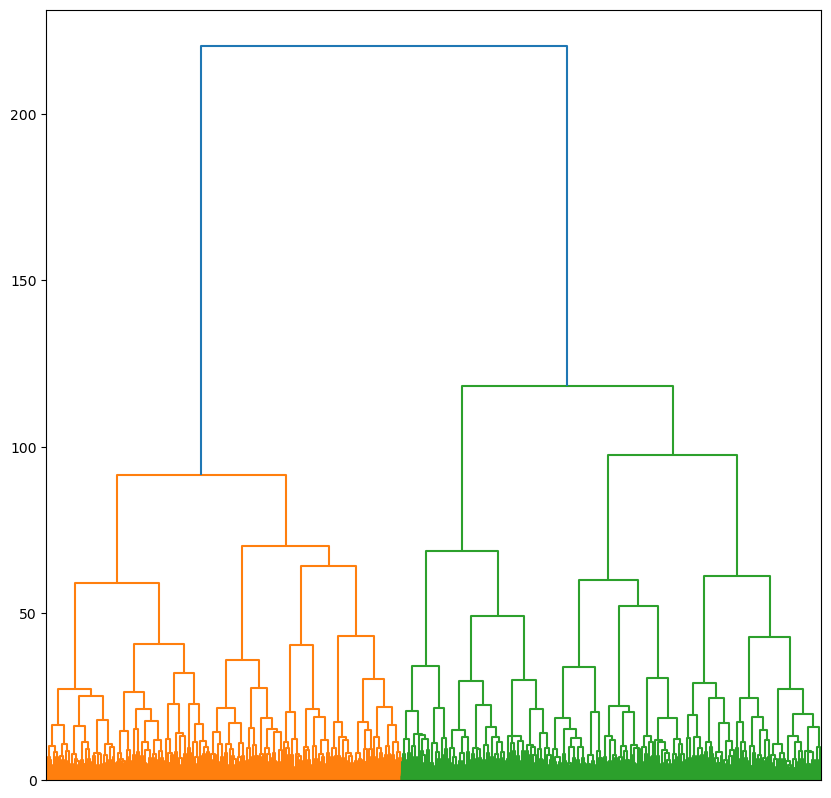

In [28]:
## final dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
fig,ax = plt.subplots(figsize=(10,10))
_ = dendrogram(linkage_matrix,ax=ax, no_labels=True)

In [99]:
final_cutoff = 50

In [100]:
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, regional_ward_morphotopes_data.index)
# clusters_description = regional_ward_morphotopes_data.groupby(final_clusters).mean()
# clusters_description = grouped_data.groupby(final_clusters).mean()
final_clusters.value_counts()

7     2809
2     2525
12    2323
3     1986
5     1908
1     1871
8     1375
11    1337
4     1289
6     1259
10    1194
9     1015
Name: count, dtype: int64

### Plotting

In [101]:
from core.cluster_validation import get_color
final_colors = pd.DataFrame(get_color(final_clusters.values), final_clusters.values).drop_duplicates()
final_colors.loc[-1] = [255,255,255]

In [102]:
region_id = 69333 


# region_id = 5883
# region_id = 86873
# region_id = 38679
# region_id = 55763
# region_id = 107131
# region_id = 99886

In [103]:
# etcs=False to read buildings, etcs=True for tessellation cells.
etcs = morphotopes_to_etcs(region_id, etcs=False, model_params=model_params)

In [104]:



## relabel
### regional_clusters = morphotopes -> regional_clusters
### final_clusters = regional_clusters -> final_clusters
etcs['final'] = etcs['morph'].map(lambda x: final_clusters.loc[regional_clusters.loc[x]] if x in regional_clusters else -1)
etcs['regional'] = etcs['morph'].map(lambda x: regional_clusters.loc[x] if x in regional_clusters else "-1")


In [105]:
# ## can run this to change colors on an exisitng layer
# layer.get_fill_color = get_color(etcs.final)

In [106]:

etcs['geometry'] = etcs.simplify(1).to_crs(epsg=4326).make_valid()
etcs = etcs[etcs['geometry'].geom_type == 'Polygon']

In [107]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.7)

CPU times: user 1.09 s, sys: 147 ms, total: 1.24 s
Wall time: 1.24 s


In [260]:
from sidecar import Sidecar
sc = Sidecar(title=f'Final Clusters - {final_cutoff}')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.DarkMatter)
with sc:
    display(m)

In [126]:
from core.cluster_validation import get_color
layer.get_fill_color = final_colors.loc[etcs.final].values.astype('uint8')

In [110]:
etcs.final.value_counts().shape

(12,)

In [149]:
grouping = pd.DataFrame()
grouping[final_cutoff] = final_clusters

### Interactive dendro

In [44]:
from core import interactive_dendrogram
import jscatter
import ipywidgets

scatter_df = interactive_dendrogram.get_dendrogram_scatter_data(linkage_matrix)

In [45]:
# selected_node = scatter.selection()[0]



# children_ids = interactive_dendrogram.get_children(
#     linkage_matrix, scatter_df.loc[selected_node, 'child'].astype(int), scatter_df.loc[selected_node, 'parent'].astype(int))
# children_morphotopes = regional_ward_morphotopes_data.iloc[children_ids].index


# idxs = children_morphotopes
# cluster_colors = np.full((etcs.shape[0], 3), 0)
# cluster_colors[etcs.regional.isin(idxs)] = [255, 255, 255]
# layer.get_fill_color = cluster_colors.astype('uint8')

def get_subcluster_children(focus):
    child, parent = linkage_matrix[focus - n, 0].astype(int), linkage_matrix[focus - n, 1].astype(int)
    children_ids = interactive_dendrogram.get_children(linkage_matrix, child, parent)
    children_morphotopes = regional_ward_morphotopes_data.iloc[children_ids].index
    return children_morphotopes


In [218]:
scatter = jscatter.Scatter(data=scatter_df, x='x', y='y', connect='group1', height=640, width=1280)
scatter.axes(grid=True)
scatter.connect(by='group1', order='order1')
click_history = dict()
# output = ipywidgets.Output()

# @output.capture(clear_output=True)
# def selection_change_handler(change):
#     display(scatter_df.loc[change.new].style.hide(axis='index'))
            
# scatter.widget.observe(selection_change_handler, names=["selection"])

# ipywidgets.HBox([scatter.show(), output])
scatter.show()

In [241]:
selected_node = scatter.selection()[0]

n = linkage_matrix.shape[0] + 1

left = scatter_df.loc[selected_node, 'child'].astype(int)
right = scatter_df.loc[selected_node, 'parent'].astype(int)

left_children = get_subcluster_children(left)
right_children = get_subcluster_children(right)

cluster_colors = np.full((etcs.shape[0], 3), 0) # everything black
cluster_colors[etcs.regional.isin(left_children)] = [141,211,199] # left blue - 1
cluster_colors[etcs.regional.isin(right_children)] = [255,255,179] # right yellow - 2
layer.get_fill_color = cluster_colors.astype('uint8')

In [242]:
left_data = regional_ward_morphotopes_data.loc[left_children].mean()
right_data = regional_ward_morphotopes_data.loc[right_children].mean()
# assert np.isclose(pd.DataFrame({1:left_data, 2: right_data}).T.values, clusters_description.values).all()

diffs = (left_data - right_data)
diffs = diffs[(diffs ** 2).sort_values(ascending=False).index].head(20)
diffs

mibCou    0.595999
mtbSWR    0.550844
ltcBuA   -0.370371
sscERI   -0.333876
sscCCo   -0.297764
sdsSWD    0.286972
ssbCCD   -0.248843
mibERI   -0.247981
ssbERI    0.225213
midRea    0.213447
ldsRea    0.186805
ssbCCo    0.180264
linWID   -0.178422
sdbAre   -0.177039
sssLin   -0.171587
stbSAl    0.169844
lddNDe   -0.168780
sdbPer   -0.165964
mtbNDi   -0.163384
ldsMSL    0.155310
dtype: float64

In [243]:
selected_node

np.uint32(35908)

In [240]:
used_keys['lddNDe']

'local node density of street network'

In [ ]:
# ## save for cutting...
# click_history[selected_node] = diffs

In [244]:
## assign clusters

In [292]:
final_cutoff = 50
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, regional_ward_morphotopes_data.index)

grouping = pd.DataFrame()
grouping[final_cutoff] = final_clusters.astype(str)

In [293]:
# for selected_node in click_history.keys():
for selected_node in [6421, 6887, 28557, 15017, 35908]:

    left = scatter_df.loc[selected_node, 'child'].astype(int)
    right = scatter_df.loc[selected_node, 'parent'].astype(int)
    
    left_children = get_subcluster_children(left)
    right_children = get_subcluster_children(right)
    
    grouping.loc[left_children, round(scatter_df.loc[selected_node, 'dist'], 2)] = str(selected_node) + '1'
    grouping.loc[right_children, round(scatter_df.loc[selected_node, 'dist'], 2)] = str(selected_node) + '2'

In [294]:
ordered_columns = grouping.columns.sort_values()
grouping = grouping[ordered_columns]

# forward cluster breakdowns to higher levels
for i, col in enumerate(ordered_columns[:-1]):
    grouping.iloc[grouping[col].notna().values, i + 1] = grouping.loc[grouping[col].notna(), col]  

In [295]:
merged_clusters = grouping[50.00]
merged_clusters = pd.Series(merged_clusters.factorize()[0], merged_clusters.index)

In [296]:
layer.get_fill_color = get_color(etcs['regional'].map(merged_clusters.to_dict()).fillna(-1).astype(int))

In [183]:
left_children

Index(['100210_10', '100342_18', '100342_19', '101313_1', '101574_1',
       '101992_10', '102127_13', '102262_42', '102801_8', '102939_2',
       ...
       '97745_1', '97745_2', '97978_10', '98107_9', '98660_19', '98716_12',
       '98958_2', '99865_28', '99886_6', '99886_7'],
      dtype='object', length=233)

In [184]:
right_children

Index(['100210_11', '100342_14', '100342_15', '102127_12', '102262_44',
       '102801_7', '102814_9', '102939_1', '103561_13', '103561_15',
       ...
       '96465_3', '96727_6', '97745_3', '97745_5', '97745_6', '97745_7',
       '98107_7', '98628_9', '98716_2', '98958_5'],
      dtype='object', length=223)

In [55]:
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, regional_ward_morphotopes_data.index)
clusters_description = regional_ward_morphotopes_data.groupby(final_clusters).mean()
# clusters_description = grouped_data.groupby(final_clusters).mean()
final_clusters.value_counts()

349    180
291    158
31     156
251    154
15     142
      ... 
322     19
111     19
152     17
313     17
149     16
Name: count, Length: 360, dtype: int64

In [56]:
multiple_clusters = pd.DataFrame()

In [57]:
multiple_clusters[selected_node] = final_clusters

In [523]:
from sklearn.neighbors import KDTree

In [524]:
tree = KDTree(regional_ward_morphotopes_data.values)

In [527]:
dists, idxs = tree.query(regional_ward_morphotopes_data.loc[['69333_66']], k=100)

In [528]:
regional_ward_morphotopes_data.iloc[idxs[0]].index

Index(['69333_66', '62954_18', '114311_66', '35141_1', '97745_5', '78792_11',
       '1154_19', '109491_60', '105385_4', '107131_445', '97745_3',
       '105090_15', '78938_32', '93793_17', '72396_10', '61183_2', '116866_31',
       '107131_447', '86873_39', '67156_11', '62954_16', '83538_29',
       '80404_68', '18557_91', '51289_3', '130658_17', '64220_42', '75642_5',
       '62193_4', '90196_6', '87947_3', '93167_16', '73611_9', '107131_441',
       '114311_65', '84554_38', '108884_27', '1154_18', '61187_17',
       '109491_63', '110908_2', '103561_13', '107131_456', '90770_55',
       '67803_4', '93504_7', '82514_3', '120961_8', '114311_64', '78938_31',
       '53525_2', '86863_4', '116866_32', '97745_6', '90075_1', '93793_10',
       '103713_6', '88950_2', '96465_1', '97978_10', '84962_7', '128286_16',
       '93167_15', '109491_59', '80313_11', '102814_9', '84420_6', '55763_24',
       '85156_4', '89921_2', '72507_21', '76038_20', '129730_34', '82773_14',
       '96727_11', '7547

In [139]:
# etcs[etcs.regional == '69333_64'].explore()